In [80]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


In [81]:
#Load the Titanic dataset from seaborn
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
gender_submission = pd.read_csv('gender_submission.csv')

# Merge the test data with the truth data
test = test.merge(gender_submission, on='PassengerId')

In [82]:
#Summary of the Statistical Data
train.info()
train.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


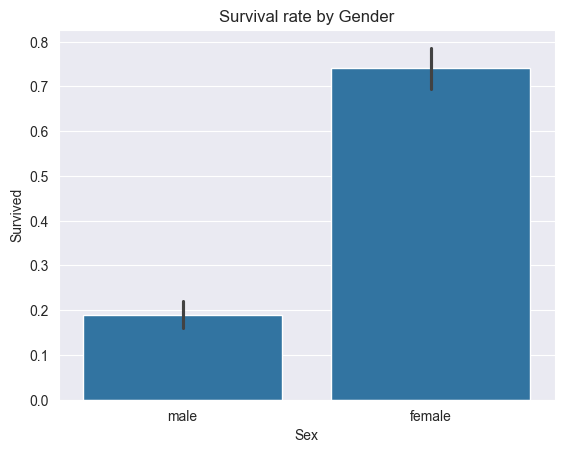

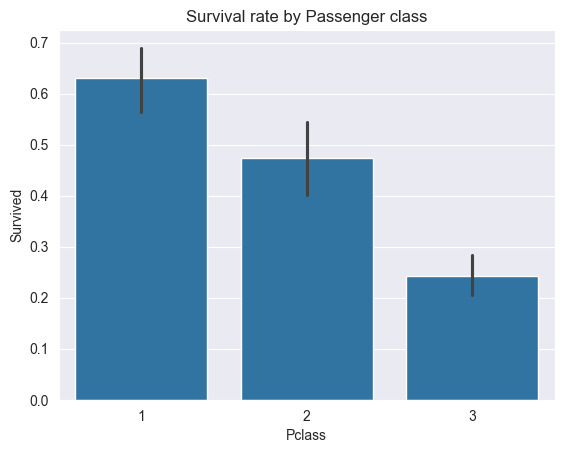

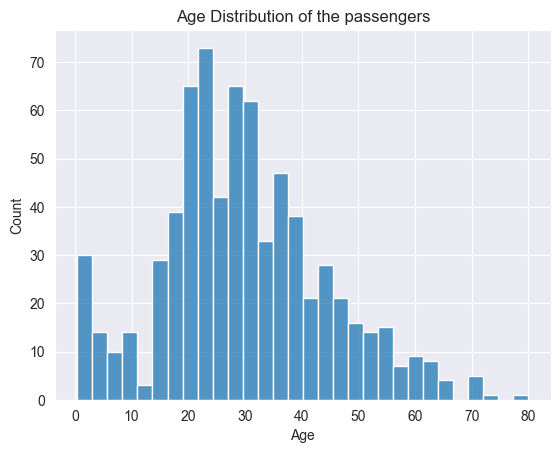

In [83]:
#visualize the data
#what is the survival rate of the passengers by gender?
sns.barplot(x='Sex', y='Survived', data=train)
plt.title('Survival rate by Gender')
plt.show()

#what is the Survival rate of the passengers by class?
sns.barplot(x='Pclass', y='Survived', data=train)
plt.title('Survival rate by Passenger class')
plt.show()

#What is the distribution of the age of the passengers?
sns.histplot(train['Age'].dropna(), kde=False, bins=30)
plt.title('Age Distribution of the passengers')
plt.show()


In [84]:
# Data Cleaning and Preprocessing
# Check for missing values
train.isnull().sum()
test.isnull().sum()

# Filling the missing Age with median
train['Age'].fillna(train['Age'].median())
test['Age'].fillna(test['Age'].median())

# Filling the missing Embarked with mode
train['Embarked'].fillna(train['Embarked'].mode()[0])
test['Embarked'].fillna(test['Embarked'].mode()[0])

# Remove the Cabin column because it has too many missing values
if 'Cabin' in train.columns:
    train = train.drop('Cabin', axis=1)
if 'Cabin' in test.columns:
    test = test.drop('Cabin', axis=1)

#Checking the dataset for missing values
print(train.isnull().sum())
print(test.isnull().sum())


PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Embarked         2
dtype: int64
PassengerId     0
Pclass          0
Name            0
Sex             0
Age            86
SibSp           0
Parch           0
Ticket          0
Fare            1
Embarked        0
Survived        0
dtype: int64


In [85]:
# Extract titles from names (e.g., Mr, Miss)
train['Title'] = train['Name'].str.extract(r' ([A-Za-z]+)\.', expand=False)
test['Title'] = test['Name'].str.extract(r' ([A-Za-z]+)\.', expand=False)

# Combine the train and test data for consistent label encoding
combined = pd.concat([train, test], axis=0).reset_index(drop=True)

# Encoding the categorical variables (Sex, Embarked, Title)
label_encoder = {}
for col in ['Sex', 'Embarked', 'Title']:
    le = LabelEncoder()
    combined[col] = le.fit_transform(combined[col])
    label_encoder[col] = le

# Split the combined data back into train and test
train = combined.iloc[:len(train)].reset_index(drop=True)
test = combined.iloc[len(train):].reset_index(drop=True)

In [86]:
# Model Training
# Create FamilySize column
train['FamilySize'] = train['SibSp'] + train['Parch'] + 1
test['FamilySize'] = test['SibSp'] + test['Parch'] + 1

# Split the train data into features and target
features = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 'Title', 'FamilySize']
X = train[features]
y = train['Survived']

# Split the data into training and testing sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

#Train Model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

In [87]:
#Prediction of the Validation set
y_pred = model.predict(X_val)
print(f' The Validation Accuracy: {accuracy_score(y_val, y_pred):.2f}')

#predication of the test set compared to the gender_submission
X_test = test[features]
test_pred =model.predict(X_test)
print(f'Test Accuracy: {accuracy_score(test["Survived"], test_pred):.2f}')


 The Validation Accuracy: 0.82
Test Accuracy: 0.84


In [88]:
feature_importance = pd.DataFrame({
    'Feature': features,
    'Importance': model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print(feature_importance)

      Feature  Importance
5        Fare    0.235508
1         Sex    0.227399
2         Age    0.223628
7       Title    0.095595
0      Pclass    0.080101
8  FamilySize    0.052507
3       SibSp    0.032856
6    Embarked    0.030487
4       Parch    0.021920


In [89]:
# Extract titles from names (e.g., Mr, Miss)
train['Title'] = train['Name'].str.extract(r' ([A-Za-z]+)\.', expand=False)
test['Title'] = test['Name'].str.extract(r' ([A-Za-z]+)\.', expand=False)

# Family size
train['FamilySize'] = train['SibSp'] + train['Parch'] + 1
test['FamilySize'] = test['SibSp'] + test['Parch'] + 1

In [90]:
output = pd.DataFrame({
    'PassengerId': test['PassengerId'],
    'Survived': test_pred
})
output.to_csv('titanic_predictions.csv', index=False)

In [91]:
# Check if 'Cabin' column exists before extracting 'Deck' information
if 'Cabin' in train.columns:
    train['Deck'] = train['Cabin'].str[0].fillna('Unknown')
if 'Cabin' in test.columns:
    test['Deck'] = test['Cabin'].str[0].fillna('Unknown')

In [92]:
train['FarePerPerson'] = train['Fare'] / train['FamilySize']
test['FarePerPerson'] = test['Fare'] / test['FamilySize']

In [93]:
bins = [0, 12, 18, 30, 50, 100]
labels = ['Child', 'Teen', 'Young Adult', 'Adult', 'Senior']
train['AgeGroup'] = pd.cut(train['Age'], bins=bins, labels=labels)

In [94]:
train['TicketFrequency'] = train.groupby('Ticket')['Ticket'].transform('count')
test['TicketFrequency'] = test.groupby('Ticket')['Ticket'].transform('count')

In [95]:
train['IsAlone'] = (train['SibSp'] + train['Parch'] == 0).astype(int)
test['IsAlone'] = (test['SibSp'] + test['Parch'] == 0).astype(int)

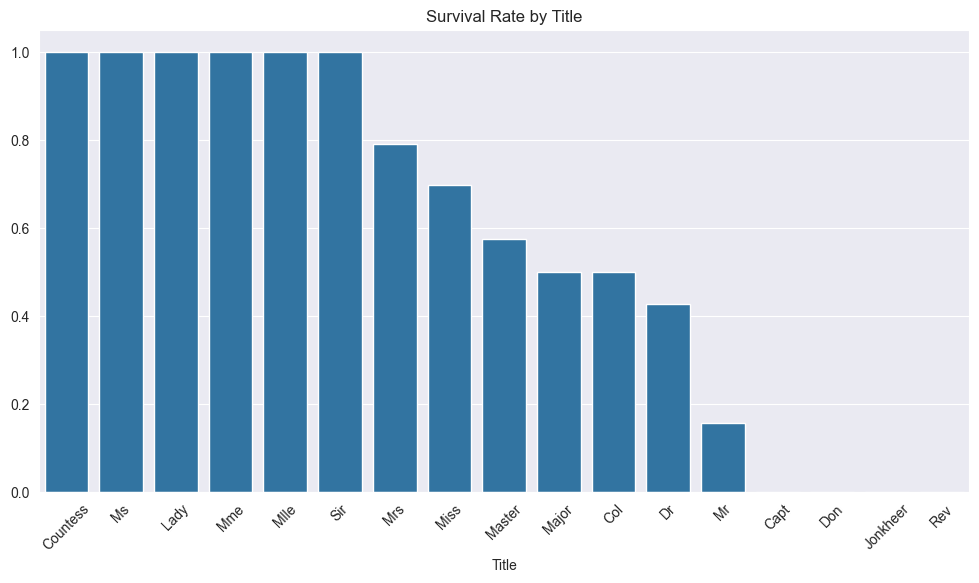

In [96]:
# Extract titles and analyze survival
title_survival = train.groupby('Title')['Survived'].mean().sort_values(ascending=False)
plt.figure(figsize=(12, 6))
sns.barplot(x=title_survival.index, y=title_survival.values)
plt.title('Survival Rate by Title')
plt.xticks(rotation=45)
plt.show()

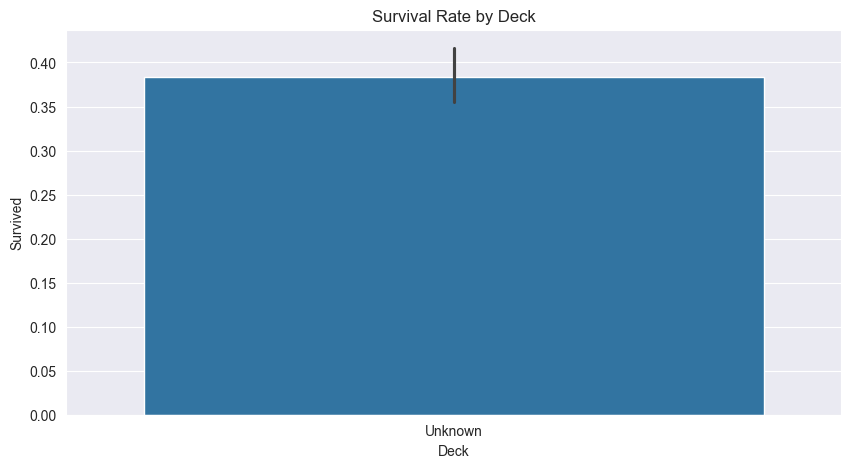

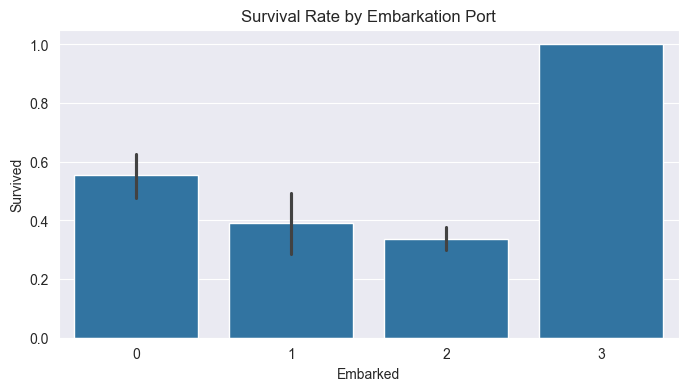

In [97]:
#1. Survival by Deck and Embarkation Port
# Question: Did survival differ by deck or embarkation port?
# Extract Deck from Cabin (if not already done)
# Check if 'Cabin' column exists before extracting 'Deck' information
if 'Cabin' in train.columns:
    train['Deck'] = train['Cabin'].str[0].fillna('Unknown')
else:
    train['Deck'] = 'Unknown'

# Survival by Deck
plt.figure(figsize=(10, 5))
sns.barplot(x='Deck', y='Survived', data=train, order=sorted(train['Deck'].unique()))
plt.title('Survival Rate by Deck')
plt.show()

# Survival by Embarkation Port
plt.figure(figsize=(8, 4))
sns.barplot(x='Embarked', y='Survived', data=train)
plt.title('Survival Rate by Embarkation Port')
plt.show()


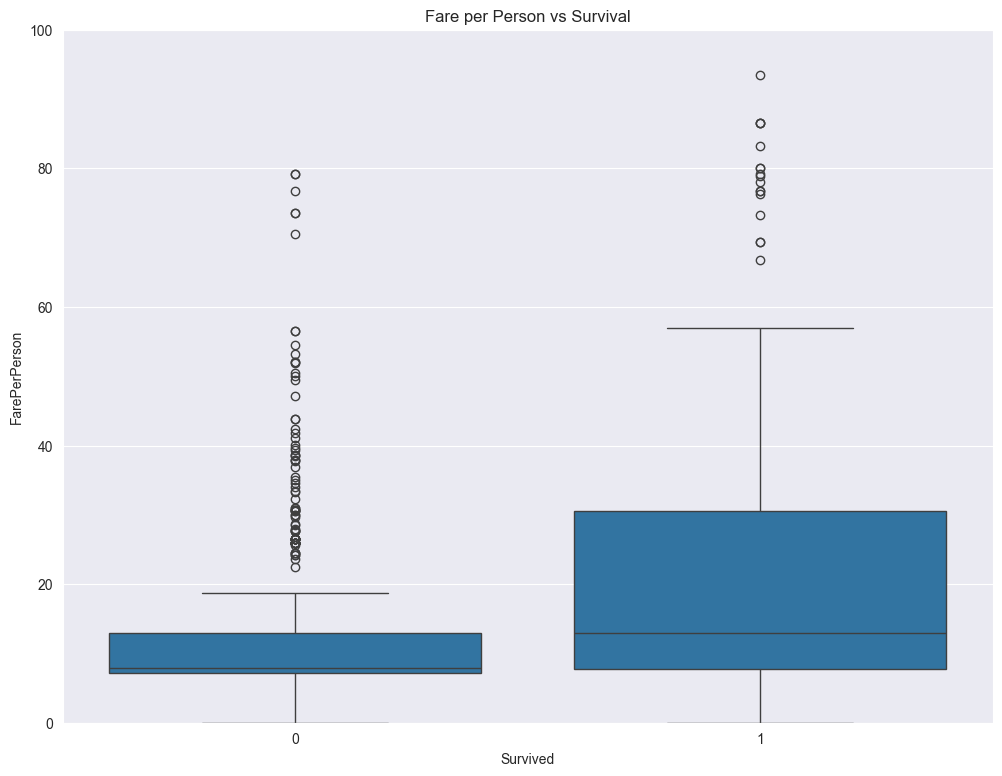

In [98]:
#Fare per Person vs Survival
#Question: How did fare per person correlate with survival?
# Create FarePerPerson
train['FarePerPerson'] = train['Fare'] / (train['SibSp'] + train['Parch'] + 1)

# Boxplot of FarePerPerson by Survival
plt.figure(figsize=(12, 9))
sns.boxplot(x='Survived', y='FarePerPerson', data=train)
plt.ylim(0, 100)  # Remove outliers for clarity
plt.title('Fare per Person vs Survival')
plt.show()

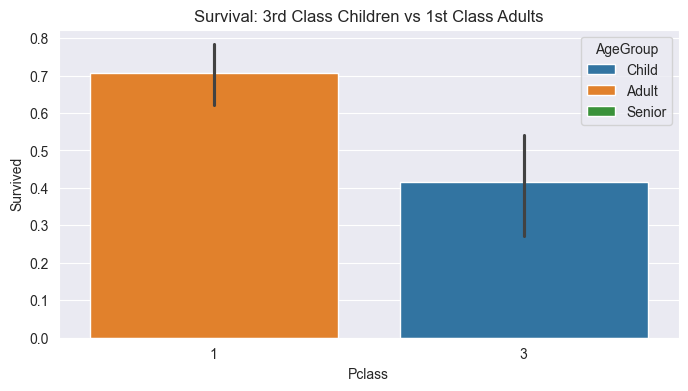

In [99]:
#Were children in 3rd class more likely to survive than adults in 1st class?
# Create age groups
train['AgeGroup'] = pd.cut(train['Age'], bins=[0, 12, 50, 100], labels=['Child', 'Adult', 'Senior'])

# Filter data
filtered = train[(train['AgeGroup'] == 'Child') & (train['Pclass'] == 3) |
                 (train['AgeGroup'] == 'Adult') & (train['Pclass'] == 1)]

# Survival comparison
plt.figure(figsize=(8, 4))
sns.barplot(x='Pclass', y='Survived', hue='AgeGroup', data=filtered)
plt.title('Survival: 3rd Class Children vs 1st Class Adults')
plt.show()

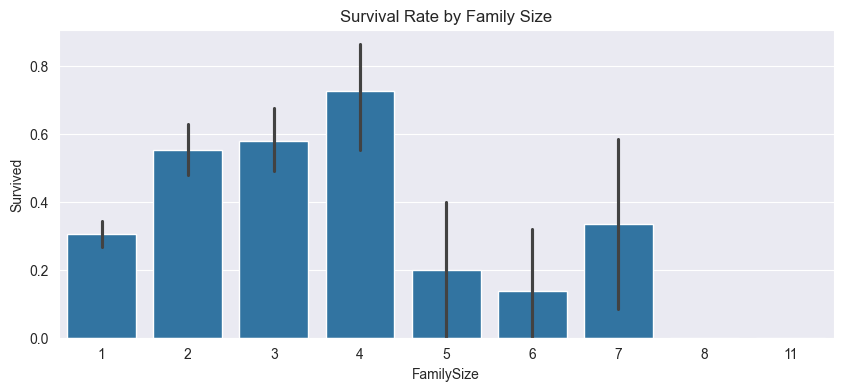

In [100]:
#Did larger families survive more?
plt.figure(figsize=(10, 4))
sns.barplot(x='FamilySize', y='Survived', data=train)
plt.title('Survival Rate by Family Size')
plt.show()

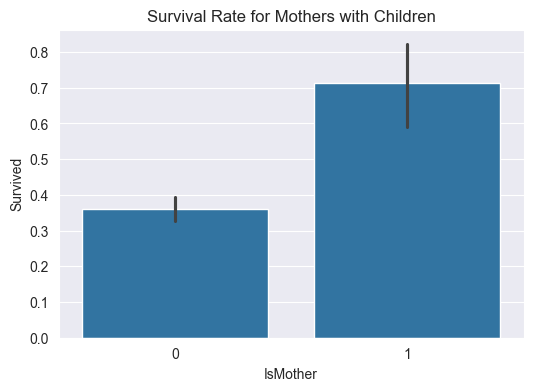

In [101]:
#Did mothers with children survive more?
# Create "IsMother" feature
train['IsMother'] = ((train['Title'] == 'Mrs') & (train['Parch'] > 0)).astype(int)

# Survival rate for mothers
plt.figure(figsize=(6, 4))
sns.barplot(x='IsMother', y='Survived', data=train)
plt.title('Survival Rate for Mothers with Children')
plt.show()

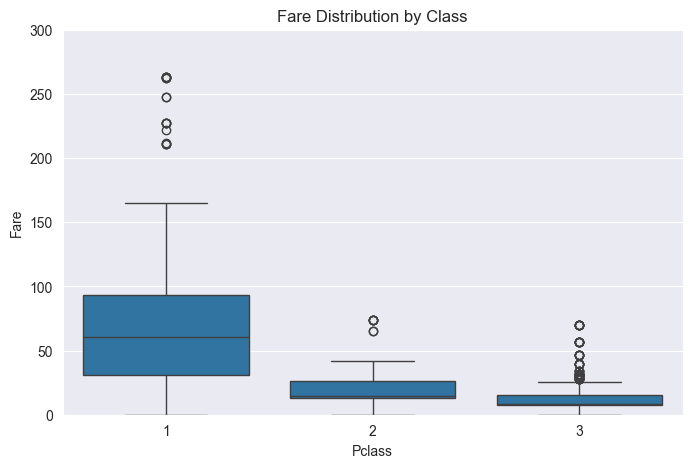

In [102]:
#Were there fare outliers in specific classes?
plt.figure(figsize=(8, 5))
sns.boxplot(x='Pclass', y='Fare', data=train)
plt.ylim(0, 300)
plt.title('Fare Distribution by Class')
plt.show()

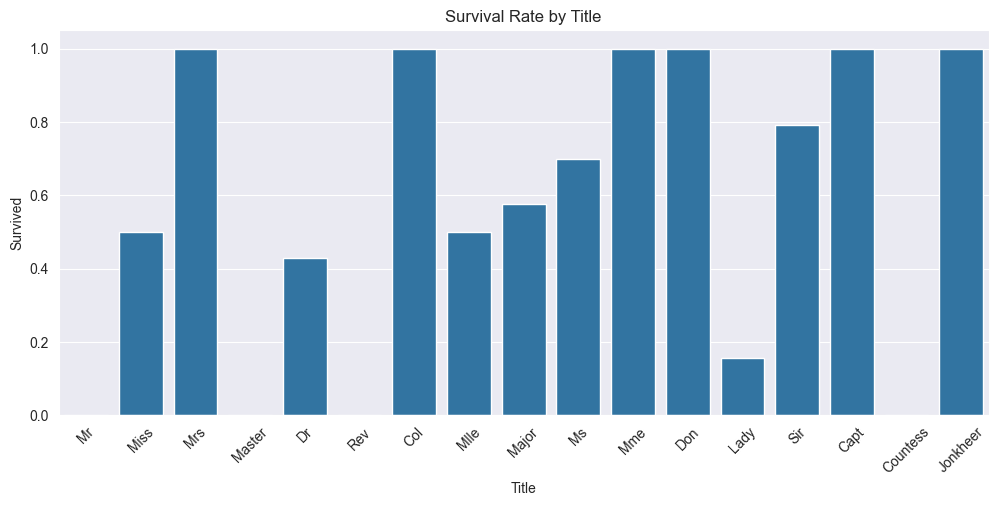

In [103]:
# Extract titles
train['Title'] = train['Name'].str.extract(r' ([A-Za-z]+)\.', expand=False)

# Survival by title
plt.figure(figsize=(12, 5))
sns.barplot(x=train['Title'].value_counts().index, y=train.groupby('Title')['Survived'].mean())
plt.xticks(rotation=45)
plt.title('Survival Rate by Title')
plt.show()

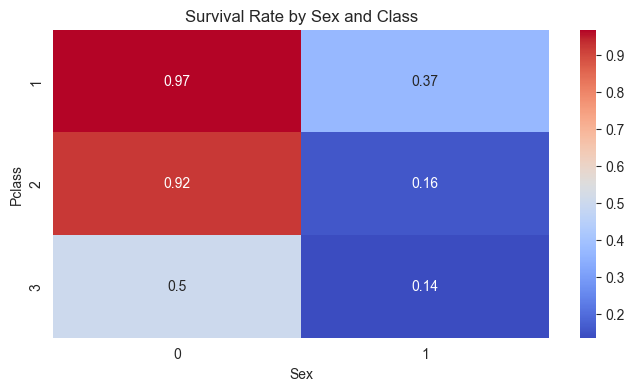

In [104]:
#How did survival differ by gender and class?
# Heatmap of survival by Sex and Pclass
pivot = train.pivot_table(index='Pclass', columns='Sex', values='Survived', aggfunc='mean')
plt.figure(figsize=(8, 4))
sns.heatmap(pivot, annot=True, cmap='coolwarm')
plt.title('Survival Rate by Sex and Class')
plt.show()

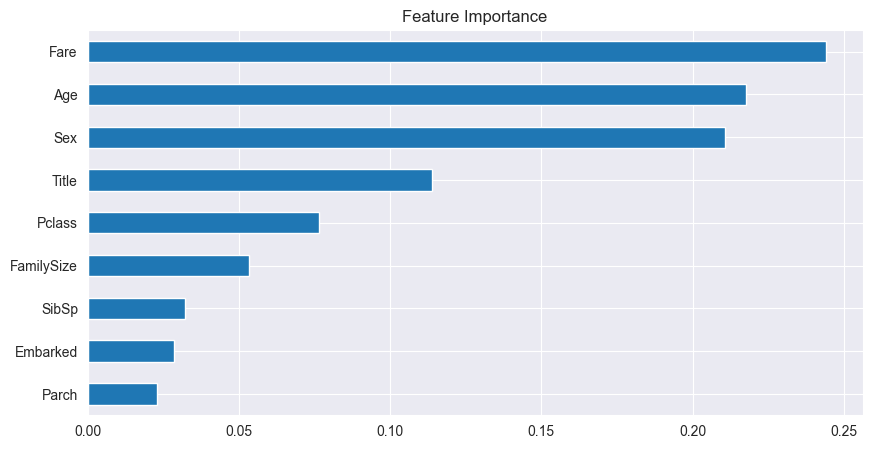

In [105]:

# Train model
model = RandomForestClassifier()
model.fit(X_train, y_train)

# Plot feature importance
plt.figure(figsize=(10, 5))
pd.Series(model.feature_importances_, index=X_train.columns).sort_values().plot(kind='barh')
plt.title('Feature Importance')
plt.show()

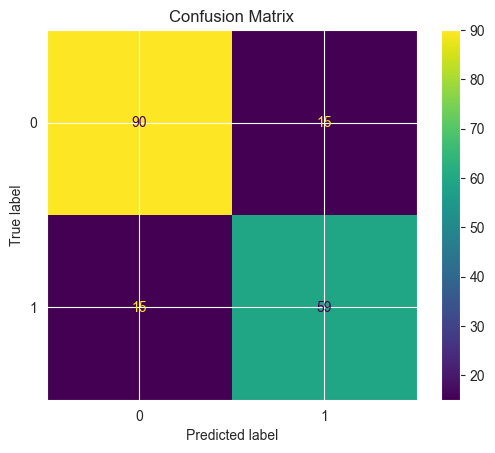

In [106]:


y_pred = model.predict(X_val)
cm = confusion_matrix(y_val, y_pred)
ConfusionMatrixDisplay(cm).plot()
plt.title('Confusion Matrix')
plt.show()